# Домашнее задание: Object Detection (train)

Обучить object detection модель из [Detectron2](https://github.com/facebookresearch/detectron2) детектировать игроков в баскетбольном матче. Число классов: 2 (две команды). 

В качестве модели следует взять одну из [предобученных моделей](https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md) (Faster R-CNN или RetinaNet).

Пример того, как обучать Detectron2 на своем датасете можно найти [здесь](https://colab.research.google.com/drive/1Xdm2KrBauT0lEyKFEiLie7nhzXajgEkH?usp=sharing).

### Датасет:
Скачайте датасет [otus_basketball_dataset](https://disk.yandex.ru/d/thdvaAKQS3ASXA) и распакуйте. Внутри находятся папки `images_train` (400 изображений) и `images_test` (100 изображений), а также файлы с аннотациями к ним: `anno_train.json` и `anno_test.json`. Файлы с аннотациями имеет следующую структуру:
```
image_name: {
     player_id: {
             'box': [x,y,w,h],
             'team': int
     }
     .....
}
....
```
Здесь `image_name` - имя изображения в соответствующей папке,<br>
`player_id` - id игрока в текущем изображении (в данном задании id не важен),<br>
`'box': [x,y,w,h]` - bounding box соответствующего игрока (координаты нормализованы от 0 до 1, поэтому их нужно домножить на размеры изображения, чтобы перевести их в целые координаты фрейма),<br>
`'team': int` - id команды к которой принадлежит игрок  в данном кадре (может принимать значения 0 или 1).


### Задачи:
1) Адаптировать датасет к внутреннему формату датасетов Detectron2 и обучить модель.

2) Посчитать метрику COCO mAP (можно использовать любую готовую библиотеку).

3) [Опционально] Реализовать вручную вычисление метрики IoU для предсказанных боксов и ground truth.

4) [Опционально] Реализовать вручную вычисление Precision и Recall и построить Precision-Recall кривую.

### Баллы:
+3 балл за пункты 1 и 2<br>
+1 балл за выполнение пункта 3<br>
+1 балл за выполнение пункта 4<br>

In [1]:
!pip install pyyaml

# PyTorch 1.10 + cuda 11.1
# https://pytorch.org/get-started/previous-versions/
!pip uninstall torch torchvision
!pip install torch==1.10.1+cu111 torchvision==0.11.2+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# Detectron2 built for PyTorch 1.10 + cuda 11.1
# https://detectron2.readthedocs.io/en/latest/tutorials/install.html
!pip uninstall detectron2
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: torch 1.10.1+cu111
Uninstalling torch-1.10.1+cu111:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchrun
    /usr/local/lib/python3.7/dist-packages/caffe2/*
    /usr/local/lib/python3.7/dist-packages/torch-1.10.1+cu111.dist-info/*
    /usr/local/lib/python3.7/dist-packages/torch/*
Proceed (y/n)? y
  Successfully uninstalled torch-1.10.1+cu111
Found existing installation: torchvision 0.11.2+cu111
Uninstalling torchvision-0.11.2+cu111:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/torchvision-0.11.2+cu111.dist-info/*
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libcudart.7be20469.so.11.0
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libjpeg.ceea7512.so.62
    /usr/local/lib/python3.7/dist-packages/torchvision.libs/libnvjpeg.8313e8da.so.11
    /usr

In [11]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.10")   # please manually install torch 1.9 if Colab changes its default version

1.10.1+cu111 True


In [12]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.engine import DefaultTrainer

In [13]:
def init_predictor(model_name, threshold=0.5):
    # Get model config and weights (download if it doesn't exist):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(model_name))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_name)
    
    # Set threshold:
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = threshold
    #cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
    
    return DefaultPredictor(cfg), cfg


In [14]:
predictor,cfg = init_predictor('COCO-Detection/retinanet_R_101_FPN_3x.yaml', 0.5)

Loading config /usr/local/lib/python3.7/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.
The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std


In [15]:
def get_basketball_dicts(img_dir):
    print("img_dir = ", img_dir)    
    if 'train' in img_dir:
      json_name = "anno_train.json"
    else:
      json_name = "anno_test.json"
    # json_file = os.path.join(img_dir, json_name)
    # print("json_name = ", json_name)
    with open(json_name) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    idx = 0
    for k, v in imgs_anns.items():
        record = {}
        
        filename = os.path.join(img_dir, k) #TODO check filename        
        # print("filename = ", filename)
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        objs = []
        for _, anno in v.items():

            box = anno["box"]
            box[0] = box[0] * width
            box[1] = box[1] * height
            box[2] = box[2] * width
            box[3] = box[3] * height
            team = anno["team"]

            obj = {
                "bbox": box,
                "bbox_mode": BoxMode.XYWH_ABS,
                "category_id": team,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
        idx +=1
    return dataset_dicts


In [18]:
for d in ["train", "test"]:
    DatasetCatalog.register("basketball_" + d, lambda d=d: get_basketball_dicts("images_" + d))
    MetadataCatalog.get("basketball_" + d).set(thing_classes=["basketball_0", "basketball_1"])
basketball_metadata = MetadataCatalog.get("basketball_train")

In [8]:
DatasetCatalog.clear()
MetadataCatalog.clear()

Визуализация изображений из обучающего набора данных

img_dir =  images_train
d =  {'file_name': 'images_train/056706.jpeg', 'image_id': 287, 'height': 720, 'width': 1280, 'annotations': [{'bbox': [158.12854123865247, 308.70705919207444, 81.51351821047007, 128.18078767571987], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [575.8293076107595, 217.89354417650813, 90.1207373329492, 120.6298838035261], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 1}, {'bbox': [961.3174814961827, 265.11344150631396, 92.52086557452157, 128.20048006942392], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 1}, {'bbox': [944.5942557029538, 105.91452889868341, 56.02513325952269, 113.67926054253479], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 1}, {'bbox': [61.59908399901502, 210.77309184565541, 64.99433925859148, 110.24543392596345], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [163.37319586600532, 412.22809732167065, 92.28217155919451, 113.76133578512905], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'

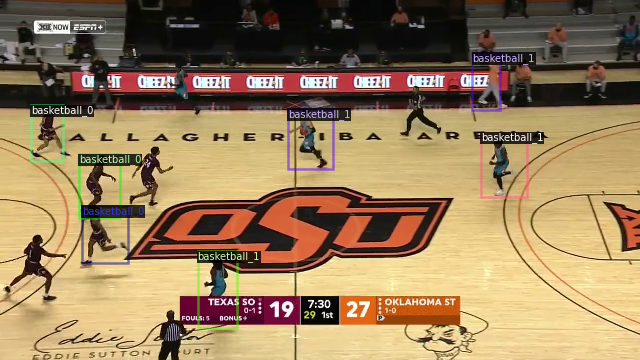

d =  {'file_name': 'images_train/006129.jpeg', 'image_id': 38, 'height': 720, 'width': 1280, 'annotations': [{'bbox': [865.9650840759364, 364.4266095327102, 92.38140904688116, 142.8409639851324], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [435.0881613468263, 332.3286918146686, 76.33448691558945, 113.18182605543421], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [731.105182869605, 203.28145434653365, 60.11601787910601, 137.69777043891435], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 1}, {'bbox': [1071.9476467904665, 368.65724373667774, 81.42838600628605, 156.55001293220934], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 1}, {'bbox': [370.2620693632798, 326.2248207048836, 116.36030405279014, 150.35162641700452], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 1}, {'bbox': [518.6185814152542, 469.8972129736386, 100.90599872734286, 146.11745510766747], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 1}, {'bbox': [667.3253455065835, 1

d =  {'file_name': 'images_train/007514.jpeg', 'image_id': 47, 'height': 720, 'width': 1280, 'annotations': [{'bbox': [725.2396428772413, 322.52192126595065, 86.39223405703214, 127.14172417755434], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [284.65753613769647, 358.1526585987296, 92.5949054433668, 158.77384129700695], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [470.4057481521829, 75.94989862132175, 84.73329898564666, 127.84260037607918], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [429.31462770030345, 246.87551969216472, 84.17958238374518, 145.60142276040858], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 1}, {'bbox': [383.19557335751307, 250.296979822895, 92.11210937839641, 140.81967484739968], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [634.9238156021421, 166.9325325872075, 72.65577058380715, 137.02062410486468], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [160.45787200930283, 

In [16]:
dataset_dicts = get_basketball_dicts("images_train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=basketball_metadata, scale=0.5)
    print("d = ", d)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

Обучение

In [19]:
cfg.DATASETS.TRAIN = ("basketball_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 900    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[07/11 21:30:52 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std


[07/11 21:31:08 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[07/11 21:31:30 d2.utils.events]:  eta: 0:16:36  iter: 19  total_loss: 1.846  loss_cls: 1.307  loss_box_reg: 0.5252  time: 1.1118  data_time: 0.0292  lr: 5.5225e-05  max_mem: 5011M
[07/11 21:31:47 d2.utils.events]:  eta: 0:14:26  iter: 39  total_loss: 0.8568  loss_cls: 0.511  loss_box_reg: 0.3505  time: 0.9758  data_time: 0.0086  lr: 0.00011073  max_mem: 5011M
[07/11 21:32:04 d2.utils.events]:  eta: 0:11:46  iter: 59  total_loss: 0.5603  loss_cls: 0.3363  loss_box_reg: 0.2402  time: 0.9227  data_time: 0.0075  lr: 0.00016623  max_mem: 5011M
[07/11 21:32:20 d2.utils.events]:  eta: 0:11:32  iter: 79  total_loss: 0.5017  loss_cls: 0.2597  loss_box_reg: 0.2343  time: 0.8986  data_time: 0.0091  lr: 0.00022172  max_mem: 5011M
[07/11 21:32:36 d2.utils.events]:  eta: 0:11:15  iter: 99  total_loss: 0.4922  loss_cls: 0.241  loss_box_reg: 0.2378  time: 0.8780  data_time: 0.0103  lr: 0.00027723  max_mem: 5011M
[07/11 21:32:53 d2.utils.events]:  eta: 0:11:00  iter: 119  total_loss: 0.4688  loss_cls:

In [20]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

img_dir =  images_test


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


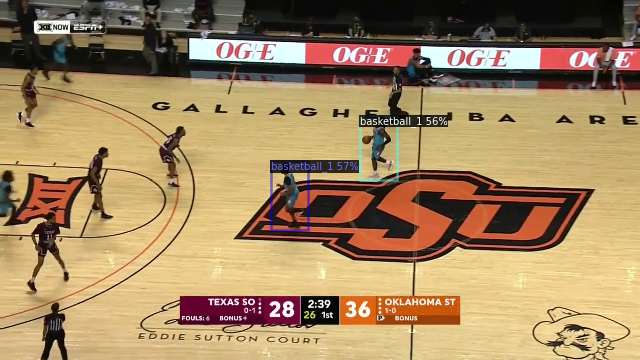

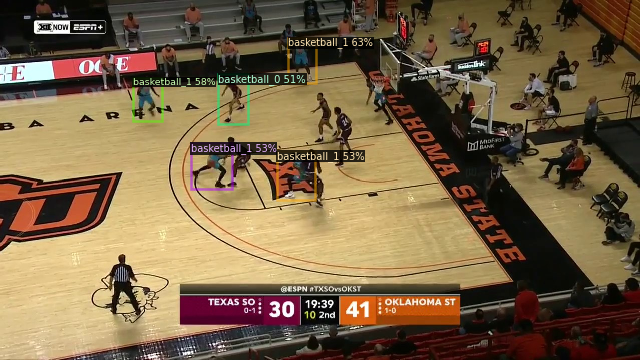

In [21]:
dataset_dicts = get_basketball_dicts("images_test")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=basketball_metadata, 
                   scale=0.5, 
                  #  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

Вычисление COCO mAp

In [22]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("basketball_test", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "basketball_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[07/11 21:44:04 d2.evaluation.coco_evaluation]: Trying to convert 'basketball_test' to COCO format ...
WARNING [07/11 21:44:04 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/basketball_test_coco_format.json'. You need to clear the cache file if your dataset has been modified.
img_dir =  images_test
[07/11 21:44:05 d2.data.build]: Distribution of instances among all 2 categories:
|   category   | #instances   |   category   | #instances   |
|:------------:|:-------------|:------------:|:-------------|
| basketball_0 | 377          | basketball_1 | 283          |
|              |              |              |              |
|    total     | 660          |              |              |
[07/11 21:44:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/11 21:44:05 d2.data.common]: Serializing 100 elements to byte tensors and concatenating

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[07/11 21:44:07 d2.evaluation.evaluator]: Inference done 11/100. Dataloading: 0.0018 s/iter. Inference: 0.1643 s/iter. Eval: 0.0002 s/iter. Total: 0.1664 s/iter. ETA=0:00:14
[07/11 21:44:12 d2.evaluation.evaluator]: Inference done 42/100. Dataloading: 0.0026 s/iter. Inference: 0.1635 s/iter. Eval: 0.0002 s/iter. Total: 0.1664 s/iter. ETA=0:00:09
[07/11 21:44:17 d2.evaluation.evaluator]: Inference done 72/100. Dataloading: 0.0026 s/iter. Inference: 0.1637 s/iter. Eval: 0.0002 s/iter. Total: 0.1666 s/iter. ETA=0:00:04
[07/11 21:44:22 d2.evaluation.evaluator]: Total inference time: 0:00:15.956792 (0.167966 s / iter per device, on 1 devices)
[07/11 21:44:22 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:15 (0.163685 s / iter per device, on 1 devices)
[07/11 21:44:22 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/11 21:44:22 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[07/11 21:44:22 d2.evaluation.coco_

Посмотрим, в каком виде получаем ground truth bbox и предсказанные bbox. Видно, что их число отличается для каждой картинки и что их порядок перепутан - учтем это при ручном подсчете IoU

In [23]:
# dataset_dicts = get_basketball_dicts("images_test")
for d in dataset_dicts:
    img = cv2.imread(d["file_name"])    
    print("gt d = ", d)
     
    outputs = predictor(img)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    pred_boxes = outputs["instances"].pred_boxes.to("cpu")
    print("pred_boxes = ", pred_boxes )    

gt d =  {'file_name': 'images_test/078176.jpeg', 'image_id': 0, 'height': 720, 'width': 1280, 'annotations': [{'bbox': [440.6702687327911, 252.5877080784919, 90.89686635523103, 116.49415981387816], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 1}, {'bbox': [404.033815897999, 190.64877770638617, 71.39509433684313, 139.32769855515988], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [376.66060155591606, 437.14344161512815, 83.26946828725433, 149.2898656005295], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 1}, {'bbox': [476.62316174540865, 143.18578262355766, 81.40728030687903, 122.35826124239804], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 1}, {'bbox': [494.3167776346326, 220.82045528444866, 67.69457747765414, 134.76741828421677], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 1}, {'bbox': [340.288688732471, 512.0414883561016, 89.20129467276423, 174.67678660635], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [463.0663440438306, 54.

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


gt d =  {'file_name': 'images_test/078246.jpeg', 'image_id': 1, 'height': 720, 'width': 1280, 'annotations': [{'bbox': [469.7886912676389, 256.8783351553313, 82.30989772573592, 136.61456332426826], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 1}, {'bbox': [454.499403982218, 412.32081324642326, 60.33861861685988, 141.01731423830057], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 1}, {'bbox': [313.8950573634088, 149.85171454668088, 60.56149505227812, 110.42729695222513], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 1}, {'bbox': [557.4236772893728, 266.3356608636236, 82.6799218702287, 167.0819780689219], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 1}, {'bbox': [81.69197138329434, 533.7759343619015, 87.7439201361708, 145.6508094383862], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [237.9216171351379, 169.0345213025153, 68.87855382540019, 115.30138025364633], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [264.7768204322335, 140.28

In [2]:
Для следующего примера число bboxes, выданных предиктором, и ground truth одинаково - в прошлом запуске этого блока предиктор выдал больше bbox.

SyntaxError: invalid syntax (348228889.py, line 1)

d =  {'file_name': 'images_test/078176.jpeg', 'image_id': 0, 'height': 720, 'width': 1280, 'annotations': [{'bbox': [440.6702687327911, 252.5877080784919, 90.89686635523103, 116.49415981387816], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 1}, {'bbox': [404.033815897999, 190.64877770638617, 71.39509433684313, 139.32769855515988], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [376.66060155591606, 437.14344161512815, 83.26946828725433, 149.2898656005295], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 1}, {'bbox': [476.62316174540865, 143.18578262355766, 81.40728030687903, 122.35826124239804], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 1}, {'bbox': [494.3167776346326, 220.82045528444866, 67.69457747765414, 134.76741828421677], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 1}, {'bbox': [340.288688732471, 512.0414883561016, 89.20129467276423, 174.67678660635], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [463.0663440438306, 54.921

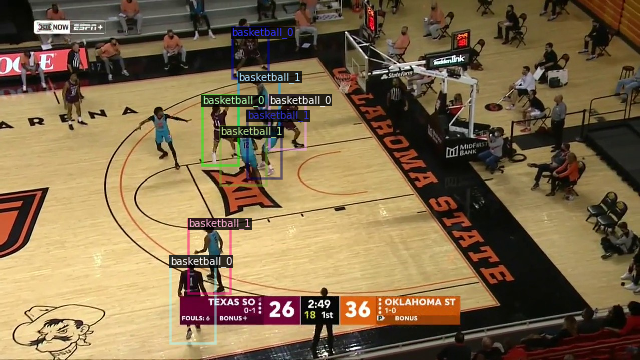

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


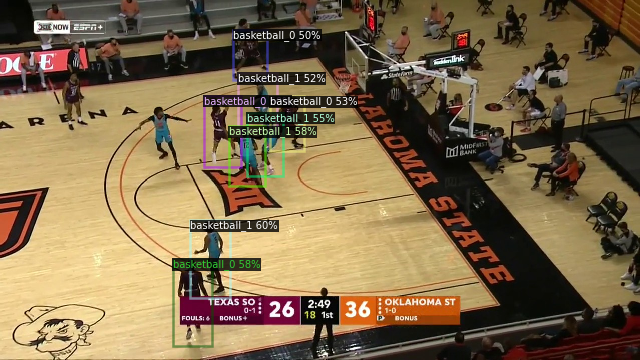

pred_boxes =  Instances(num_instances=8, image_height=720, image_width=1280, fields=[pred_boxes: Boxes(tensor([[380.5539, 440.9431, 459.6680, 596.2856],
        [346.3544, 518.0491, 424.1165, 692.8018],
        [458.1136, 252.9628, 530.1788, 372.2390],
        [493.7902, 225.3992, 566.1426, 352.5192],
        [540.3241, 192.5990, 608.4207, 302.4566],
        [475.2240, 146.2765, 554.3608, 259.9601],
        [466.7061,  59.5713, 534.4400, 159.4440],
        [407.2853, 191.3053, 481.5811, 334.4959]])), scores: tensor([0.5965, 0.5842, 0.5791, 0.5454, 0.5299, 0.5203, 0.5041, 0.5018]), pred_classes: tensor([1, 0, 1, 1, 0, 1, 0, 0])])


In [24]:
# dataset_dicts = get_basketball_dicts("images_test")
d= dataset_dicts['file_name' == 'images_test/083208.jpeg']
im = cv2.imread(d["file_name"])
visualizer_gt = Visualizer(im[:, :, ::-1], metadata=basketball_metadata, scale=0.5)
print("d = ", d)
out = visualizer_gt.draw_dataset_dict(d)
cv2_imshow(out.get_image()[:, :, ::-1])

outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],
                metadata=basketball_metadata, 
                scale=0.5, 
              #  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])
print("pred_boxes = ", outputs["instances"].to("cpu"))

Подсчет IoU

In [25]:
def intersection_over_union(gt, pred):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(gt[0], pred[0])
    yA = max(gt[1], pred[1])
    xB = min(gt[2], pred[2])
    yB = min(gt[3], pred[3])
    # if there is no overlap between predicted and ground-truth box
    if xB < xA or yB < yA:
        return 0.0
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA ) * max(0, yB - yA )
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (gt[2] - gt[0] ) * (gt[3] - gt[1] )
    boxBArea = (pred[2] - pred[0]) * (pred[3] - pred[1] )
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    if float(boxAArea + boxBArea - interArea) == 0:
        return -1
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

img_dir =  images_test
d =  {'file_name': 'images_test/078176.jpeg', 'image_id': 0, 'height': 720, 'width': 1280, 'annotations': [{'bbox': [440.6702687327911, 252.5877080784919, 90.89686635523103, 116.49415981387816], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 1}, {'bbox': [404.033815897999, 190.64877770638617, 71.39509433684313, 139.32769855515988], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [376.66060155591606, 437.14344161512815, 83.26946828725433, 149.2898656005295], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 1}, {'bbox': [476.62316174540865, 143.18578262355766, 81.40728030687903, 122.35826124239804], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 1}, {'bbox': [494.3167776346326, 220.82045528444866, 67.69457747765414, 134.76741828421677], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 1}, {'bbox': [340.288688732471, 512.0414883561016, 89.20129467276423, 174.67678660635], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}, {'bbox': [46

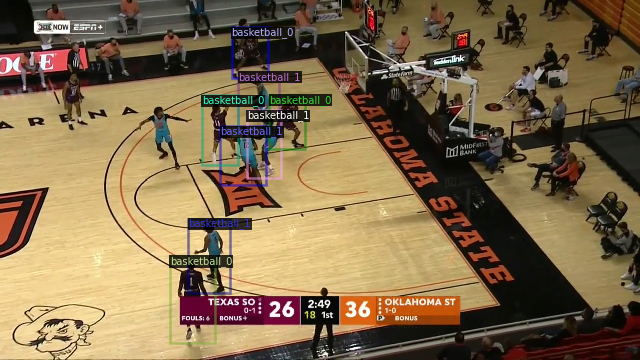

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


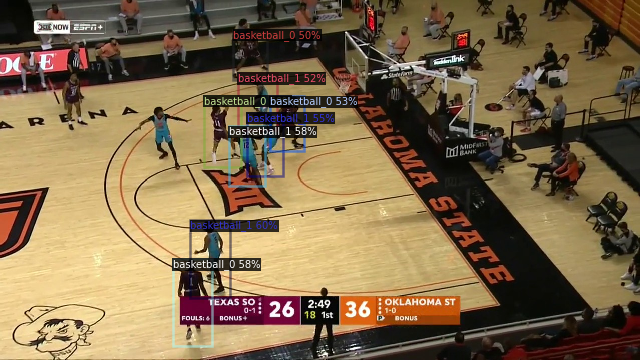

pred_boxes =  Boxes(tensor([[380.5539, 440.9431, 459.6680, 596.2856],
        [346.3544, 518.0491, 424.1165, 692.8018],
        [458.1136, 252.9628, 530.1788, 372.2390],
        [493.7902, 225.3992, 566.1426, 352.5192],
        [540.3241, 192.5990, 608.4207, 302.4566],
        [475.2240, 146.2765, 554.3608, 259.9601],
        [466.7061,  59.5713, 534.4400, 159.4440],
        [407.2853, 191.3053, 481.5811, 334.4959]]))
[tensor(0.8485), tensor(0.8713), tensor(0.8733), tensor(0.8858), tensor(0.8170), tensor(0.8723), tensor(0.8819)]
['images_test/078176.jpeg', 'images_test/078176.jpeg', 'images_test/078176.jpeg', 'images_test/078176.jpeg', 'images_test/078176.jpeg', 'images_test/078176.jpeg', 'images_test/078176.jpeg', 'images_test/078176.jpeg']


In [26]:
dataset_dicts = get_basketball_dicts("images_test")
d= dataset_dicts['file_name' == 'images_test/083208.jpeg']
im = cv2.imread(d["file_name"])
visualizer_gt = Visualizer(im[:, :, ::-1], metadata=basketball_metadata, scale=0.5)
print("d = ", d)
out = visualizer_gt.draw_dataset_dict(d)
cv2_imshow(out.get_image()[:, :, ::-1])

outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
v = Visualizer(im[:, :, ::-1],
                metadata=basketball_metadata, 
                scale=0.5, 
              #  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])
pred_boxes = outputs["instances"].pred_boxes.to("cpu")
print("pred_boxes = ", pred_boxes)
ious = []
ious_undefined = []
for node in d["annotations"]: #assume cnt(gt_boxes) <= cnt(pred_boxes)
    gt_box = node['bbox']
    gt_box[2] += gt_box[0] 
    gt_box[3] += gt_box[1]
    for pred_box in pred_boxes:
        if abs(pred_box[0] - gt_box[0]) < 15 and abs(pred_box[1] - gt_box[1]) < 15:
            ious.append(intersection_over_union(gt_box, pred_box))
            continue
    else:
        ious_undefined.append(d["file_name"])
print(ious)
print(ious_undefined)

In [31]:
ious = []
ious_undefined = []
for d in dataset_dicts:
    im = cv2.imread(d["file_name"])

    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    pred_boxes = outputs["instances"].pred_boxes.to("cpu")

    for node in d["annotations"]: #assume cnt(gt_boxes) <= cnt(pred_boxes)
        gt_box = node['bbox']
        gt_box[2] += gt_box[0] 
        gt_box[3] += gt_box[1]
        for pred_box in pred_boxes:
            if abs(pred_box[0] - gt_box[0]) < 15 and abs(pred_box[1] - gt_box[1]) < 15:
                ious.append(intersection_over_union(gt_box, pred_box))
                break
        else:
            ious_undefined.append(d["file_name"])
print(np.shape(ious), np.mean(ious))
print(np.shape(ious_undefined))

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


(375,) 0.0463798
(285,)


In [30]:
sum(1 for iou in ious if iou < 0)

0